In [1]:
## download important libs

from pyspark import SparkContext
import nltk
from nltk.probability import FreqDist

In [2]:
## import libs for taking a random sample and further processing
from pyspark.sql.functions import rand 
from pyspark.sql.functions import from_unixtime
from pyspark.sql.functions import dayofweek
from pyspark.sql.functions import date_format
from pyspark.sql.functions import dayofmonth

## load the data
df = spark.read.csv("dbfs:/FileStore/tmp/all_df.csv", header=True)

## take a random sample of df
## sample size is chosen to be 100000
## since community edition is very limited in terms of storage
## .take() function returns list of rows
df_sample = df.orderBy(rand()).sample(withReplacement=False, fraction=1.0, seed=1000).take(100000)

## make dataframe from that sample
df_sample_ = spark.createDataFrame(df_sample).toDF("unix_date", "comment", "neg", "neu", "pos", "com")

## several functions are used to change date information from unix
## make new date_new column
df_sample_ = df_sample_.withColumn("date_new", from_unixtime("unix_date"))

## make new weekday column
df_sample_= df_sample_.withColumn("weekday", dayofweek("date_new"))

## make new weekday_name column
df_sample_ = df_sample_.withColumn("weekday_name", date_format("date_new", 'E'))

## make new dayofmonth column
df_sample_ = df_sample_.withColumn("dayofmonth", dayofmonth("date_new"))

## save this sample 
df_sample_.write.format("com.databricks.spark.csv").option("header", "true").save("dbfs:/FileStore/tmp/sample_df.csv")


In [3]:
## read the data
df_sample = spark.read.csv("dbfs:/FileStore/tmp/sample_df.csv", header=True)

In [4]:
## clearly sample data as we have expected
## comment and sentiment scores as well as weekday names are present
df_sample.show(10)

+----------+--------------------+-----+-----+-----+-------+-------------------+-------+------------+----------+
 unix_date| comment| neg| neu| pos| com| date_new|weekday|weekday_name|dayofmonth|
+----------+--------------------+-----+-----+-----+-------+-------------------+-------+------------+----------+
1312943860|reason dislike do...|0.281|0.571|0.148|-0.2023|2011-08-10 02:37:40| 4| Wed| 10|
1314580683|mind queue lesbia...| 0.0| 1.0| 0.0| 0.0|2011-08-29 01:18:03| 2| Mon| 29|
1313046107|holy crap thought...|0.464|0.536| 0.0|-0.3818|2011-08-11 07:01:47| 5| Thu| 11|
1313964092| noooow| 0.0| 1.0| 0.0| 0.0|2011-08-21 22:01:32| 1| Sun| 21|
1313858003|gt dont see post ...|0.449|0.409|0.141|-0.9556|2011-08-20 16:33:23| 7| Sat| 20|
1314750276|everyone friend s...|0.252|0.488| 0.26| 0.0258|2011-08-31 00:24:36| 4| Wed| 31|
1313424685|always used call ...|0.375|0.625| 0.0| -0.34|2011-08-15 16:11:25| 2| Mon| 15|
1312569056|apache good call ...| 0.15|0.646|0.204| 0.2732|2011-08-05 18:30:56| 6| Fri| 5|
1314544010|rgaming seems pro...|0.069| 0.78| 0.15| 0.4215|2011-08-28 15:06:50| 1| Sun| 28|
1312226275|bit difference si...|0.082|0.845|0.073| 0.1531|2011-08-01 19:17:55| 2| Mon| 1|
+----------+--------------------+-----+-----+-----+-------+-------------------+-------+------------+----------+
only showing top 10 rows

In [5]:
from pyspark.sql.functions import col , column

df_sample_ = df_sample.withColumn("dayofmonth", df_sample["dayofmonth"].cast("integer"))
df_sample_ = df_sample_.withColumn("neg", df_sample["neg"].cast("double"))
df_sample_ = df_sample_.withColumn("neu", df_sample["neu"].cast("double"))
df_sample_ = df_sample_.withColumn("pos", df_sample["pos"].cast("double"))
df_sample_ = df_sample_.withColumn("com", df_sample["com"].cast("double"))
df_sample_ = df_sample_.withColumn("weekday", df_sample["weekday"].cast("integer"))

In [6]:
## the column types have changed
df_sample_.printSchema()

root
-- unix_date: string (nullable = true)
-- comment: string (nullable = true)
-- neg: double (nullable = true)
-- neu: double (nullable = true)
-- pos: double (nullable = true)
-- com: double (nullable = true)
-- date_new: string (nullable = true)
-- weekday: integer (nullable = true)
-- weekday_name: string (nullable = true)
-- dayofmonth: integer (nullable = true)

In [7]:
df_sample_.show(5)

+----------+--------------------+-----+-----+-----+-------+-------------------+-------+------------+----------+
 unix_date| comment| neg| neu| pos| com| date_new|weekday|weekday_name|dayofmonth|
+----------+--------------------+-----+-----+-----+-------+-------------------+-------+------------+----------+
1312943860|reason dislike do...|0.281|0.571|0.148|-0.2023|2011-08-10 02:37:40| 4| Wed| 10|
1314580683|mind queue lesbia...| 0.0| 1.0| 0.0| 0.0|2011-08-29 01:18:03| 2| Mon| 29|
1313046107|holy crap thought...|0.464|0.536| 0.0|-0.3818|2011-08-11 07:01:47| 5| Thu| 11|
1313964092| noooow| 0.0| 1.0| 0.0| 0.0|2011-08-21 22:01:32| 1| Sun| 21|
1313858003|gt dont see post ...|0.449|0.409|0.141|-0.9556|2011-08-20 16:33:23| 7| Sat| 20|
+----------+--------------------+-----+-----+-----+-------+-------------------+-------+------------+----------+
only showing top 5 rows

In [8]:
from pyspark.sql.functions import log, avg

## lets see average sentiment scores for each weekday
## 0 stands for saturday
display(df_sample_.select("weekday_name","com").groupby("weekday_name").agg(avg("com")).sort("weekday_name"))

weekday_name,avg(com)
Fri,0.12777513359197717
Mon,0.1330471843003414
Sat,0.12287625919374356
Sun,0.12409269284064667
Thu,0.13081108811987152
Tue,0.1275137381667052
Wed,0.13799052625396463


In [9]:
## take only comments column as list
comments = df_sample_.select('comment').take(100000)
comments = [a['comment'] for a in comments]


## join comments
comments_ = []

for a in comments:
  if type(a) != type(None):
    comments_.extend(a.split(' '))


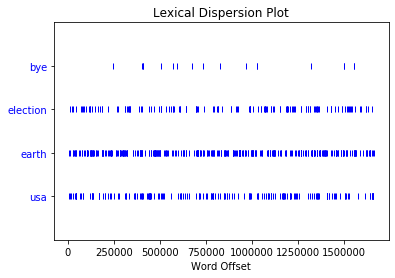

In [10]:
## Here, I plot lexical dispersion of some words
## It shows at what part these words occured

text = nltk.Text(comments_)
text.dispersion_plot(['bye', 'election', 'earth', 'usa'])

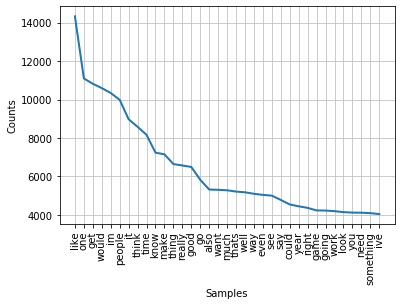

In [11]:
## I plot mostly used words by counts

fdist1 = FreqDist(comments_)
fdist1.plot(35, cumulative=False)

## obviously, mostly used words are "like", "one", "get" and etc.